# Task description

Implement an algorithm that allows us to distinguish the likely home locations of a user from his likely work locations.

A person might have multiple home and work locations, or might not have a work location at all. The data might be noise, incorrect and/or incomplete.

The data is provided in a csv file containing the locations where a person was stationary for a certain amount of time. 
The csv-file contains the following fields:

- Latitude: The latitude of the detected GPS coordinates 
- Longitude: The longitude of the detected GPS coordinates
- Timestamp: The start time of the stationary in the following format:
    - YYYY = year
    - MM = month of year
    - dd = day of month
    - HH=hourofday
    - mm = minute of hour
    - Z = timezone offset
- Duration: The length of time the person was stationary (in milliseconds)

# Solution outline

Following are the key ideas underlying the development of the solution. We cluster visited locations into groups based on the spatial proximity to identify subsets of locations with similar characteristics. The hope is that these characteristics are useful for identifying a person’s behaviour and locations of interest (work and home). We select a single location as a cluster representative. This is a candidate to be work/home. We represent a cluster representative as a vector of features. This also involves using the information of other locations in the cluster. We define one feature vector to represent a typical home location, and one feature vector to represent a typical work location. We assess the similarity of the candidate locations with work/home using a cosine similarity measure. For each candidate location (cluster representative), it yields two values measuring its similarity with typical home/work. These similarities are transformed into probabilities using softmax. Thus, each cluster representative is assigned a probability of being either person’s work or home. Final predictions are made using a decision threshold.

We use the spatial data for clustering locations and the temporal data for constructing feature vectors. The time is discretized into 10-minute intervals yielding 144 timeslots during a day. Each timeslot represents a unit of time. When devising features, we distinguish: (i) the business day and (ii) the weekend day. We represent a location by a feature vector whose elements are the expected numbers of a person to be in this location at specific timeslots considering the business and weekend days of a week. Since two types of days are considered (business and weekend), a feature vector has $144*2=288$ elements where indexes $[0:144]$ correspond to business day and indexes $[144:288]$ correspond to weekend day.

To get a feature representation for the typical home and the typical work, the following assumptions are made:
- A person is at work from 09:00 to 18:00 (Monday-Friday).
- A person is at home from 00:00 to 07:00 (Monday-Friday) and stays all the time during weekend.

For instance, the work feature vector has values of $5$ for timeslots from 09:00 to 18:00, because a person is expected to be at work during these timeslots for $5$ business days. All other elements are $0$ because the person is not expected to be at work during the night and the weekend.

To make the predictions, we go through the following steps:

1. Process the data: (i) removing some noise, (ii) representing the temporal data using timeslots, (iii) adding estimated locations for some missing timeslots. 
    
2. Cluster locations using the spatial data.

3. Select centers as cluster representatives.

4. Compute features for: cluster centers, the typical work and the typical home.

5. Estimate similarity between cluster centers and home/work vectors.

6. Based on similarity measures compute probabilities for cluster centers to be home or work.

7. Make predictions and visualize the results.

# Make necessary imports

In [1]:
import pandas as pd
import numpy as np
import math
import unittest

from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics 
from sklearn.metrics.pairwise import haversine_distances

from scipy.spatial import distance
from scipy.special import softmax
from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")

### Load and explore data

In [2]:
# load data
df_original = pd.read_csv('data/locations/person.csv', sep=';')

# Displays general information about the original data       
print(df_original.info())
print()
print('Missing values percentage')
print(df_original.isna().sum()/len(df_original))
print()
print(df_original.describe())

# show dataframe
df_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 4 columns):
latitude                     763 non-null float64
longitude                    763 non-null float64
start_time(YYYYMMddHHmmZ)    763 non-null object
duration(ms)                 763 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 23.9+ KB
None

Missing values percentage
latitude                     0.0
longitude                    0.0
start_time(YYYYMMddHHmmZ)    0.0
duration(ms)                 0.0
dtype: float64

         latitude   longitude  duration(ms)
count  763.000000  763.000000  7.630000e+02
mean    51.181121    4.337685  8.995766e+06
std      0.097911    0.286983  1.645817e+07
min     50.811398    3.287886  1.390000e+02
25%     51.205132    4.387313  1.227740e+05
50%     51.213875    4.404816  7.260170e+05
75%     51.216276    4.411593  9.506687e+06
max     51.586678    5.091093  1.631741e+08


,latitude,longitude,start_time(YYYYMMddHHmmZ),duration(ms)
0,51.057022,3.714476,201312250036+0100,19593588
1,51.056984,3.714681,201312250608+0100,30460679
2,51.038406,3.729655,201312251451+0100,964169
3,50.880190,4.251147,201312251514+0100,262475
4,50.861668,4.475020,201312251524+0100,64461


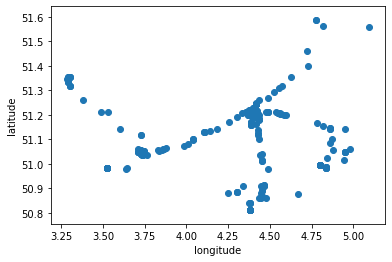

In [3]:
# visualize the data
plt.plot(figsize=(20,5))
plt.scatter(df_original['longitude'], df_original['latitude']) 
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()
 

In the following we use:

__detection__ - an instance of the __Detection__ class whose methods implement the outlined approach

__df__ - a list of data frames obtained after processing original data

__df_unique__ - a list of data frames that are obtained by dropping duplicates from __dfs__ 

__weights__ - weights used for clustering that are assigned to points in __df_unique__

__model__ - models obtained after applying clustering using __df_unique__ and __weights__

In [4]:
class Detection(object):
    """
    This class implements methods to accomplish the outlined solution.
    """

    def distance(self, loc1, loc2, radius=6371.):
        """
        Compute the Haversine distance between two locations with values in radians.
        The Haversine (or great circle) distance is the angular distance 
        between two points on the surface of a sphere.
        
        Parameters:
        loc1: list 
        loc2: list  
        
        Returns:
        radius: float - approximate radius of earth in km (default: 6371)
        """ 
        h_d = haversine_distances([loc1, loc2])[0][1]
        
        return h_d*radius # distance in km   
    
    
    def preprocess(self, df, n_timeslots=144):    
        """ 
        Preprocesses the data:
        - converts time data into phython datetime making it index of the dataframe
        - defines discrete timeslots
        - estimates location in some timeslots
        """         
        # Convert time into datetime object
        # Example: 201312251147-0300 => datetime.fromisoformat('2011-11-04T00:05:23+04:00')
        fun = lambda s: datetime.fromisoformat('{}-{}-{}T{}:{}:{}'.format(s[0:4], s[4:6], s[6:8], s[8:10], s[10:15], s[15:17]))
        df['datetime'] = df['start_time(YYYYMMddHHmmZ)'].apply(fun)
        df.set_index('datetime', inplace=True)
        df.sort_index(inplace=True)

        dct = {}

        for index, row in df.iterrows():

            step = 0        
            start = datetime(index.year, index.month, index.day, index.hour, int(index.minute/10)*10, tzinfo=index.tzinfo)

            while step <= row['duration(ms)']:            

                # determine time slot at which a person is at the given location
                time_slot = start + timedelta(milliseconds=step)

                # error measurements are tackled by rounding to 3 decimal, limitig spacial precision to 111.32m
                dct[time_slot] = [round(row.latitude,3), round(row.longitude,3)]               

                # increment step
                step += 600000

        
        # creat new data frame
        rows = [[key, val[0], val[1]] for key, val in dct.items()]

        df_new = pd.DataFrame(data=rows, columns=['datetime', 'latitude', 'longitude'])

        df_new.set_index('datetime', inplace=True)
        df_new.sort_index(inplace=True)         

        # fill some missing intervals if certain conditions are satisfied
        dt_min = timedelta(minutes=10)
        dt_max = timedelta(minutes=30)

        dct = {}

        for i in range(1, len(df)):

            dt = df_new.index[i] - df_new.index[i-1]

            if dt > dt_min and dt <= dt_max: # if the difference between missing timeslots is limited

                p0 = [df_new.iloc[i-1].latitude, df_new.iloc[i-1].longitude]
                p1 = [df_new.iloc[i].latitude, df_new.iloc[i].longitude]

                dist = detection.distance(np.radians(p0).tolist(), np.radians(p1).tolist())

                if dist < 1.: # if distance is less that 1km

                    p_estim = [round((p0[0]+p1[0])/2, 3), round((p0[1]+p1[1])/2, 3)]

                    step = 10
                    time_slot = df_new.index[i-1] + timedelta(minutes=step)
                    while time_slot < df_new.index[i]:                    
                        dct[time_slot] = p_estim
                        step += 10
                        time_slot = df_new.index[i-1] + timedelta(minutes=step)

        # insert new values into dataframe with processed data
        rows = [[key, val[0], val[1]] for key, val in dct.items()]

        df_tmp = pd.DataFrame(data=rows, columns=['datetime', 'latitude', 'longitude'])  
        df_tmp.set_index('datetime', inplace=True)

        df_new = pd.concat([df_new, df_tmp], axis=0)    
        df_new.sort_index(inplace=True)                 

        return df_new
    
    
    def clustering(self, df, weights, alg='dbscan'):
        """
        performs clustering returning the resulting model
        """        
        # implemented algorithms, used as "switch" operator
        algorithms = {'dbscan': self.dbscan, 'kmeans': self.kmeans}
        
        # get location coordinates (radians)            
        data = self.get_coordinates(df)

        # fit and get model with best configuration
        model = algorithms[alg](data, weights) 
            
        return model
    
        
    def dbscan(self, data, weights):
        """
        performs clustering using DBSCAN algorithm, finding the best configuration
        """            
        best_score, best_model = -1., None

        for eps_ in [0.001, 0.025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]:
            for min_samples_ in range(1, 11):

                model = DBSCAN(eps=eps_, min_samples=min_samples_, algorithm='ball_tree', metric='haversine').fit(data, weights)

                if len(set(model.labels_)) == 1:
                    continue

                score = metrics.silhouette_score(data, model.labels_, random_state=2)

                if score > best_score:
                    best_score, best_model = score, model

        if best_model is None: # safeguard
            best_model = DBSCAN(algorithm='ball_tree', metric='haversine').fit(data, weights)
            
        return best_model
    
    
    def kmeans(self, data, weights, K=10):
        """
        performs clustering using KMeans algorithm, finding the best configuration
        """                    
        best_score, best_model = -1., None

        for k in range(2, K+1):

            model = KMeans(n_clusters=k, random_state=0).fit(data, weights)  

            score = metrics.silhouette_score(data, model.labels_, random_state=2)

            if score > best_score:
                best_score, best_model = score, model
            
        return best_model
    
    
    def get_coordinates(self, df):
        """
        returns matrix with coordinates in radians
        """        
        return np.radians( df.as_matrix(columns=['latitude', 'longitude']) )
    
    
    def get_cluster_center(self, df):
        """
        Finds cluster center using df with points from the same cluster
        """    
        coords = self.get_coordinates(df) 
        centroid = np.mean(coords, axis=0)        
        center = min(coords, key=lambda x: self.distance(x.tolist(), centroid.tolist()))

        return np.array(center)
    
    
    def get_within_radius(self, df, center, radius=1.):
        """
        Returns all visited locations within the specified radius
        This is used to select the most representative points from the proximity of the cluster center
        """        
        coords = self.get_coordinates(df)
        dist = np.apply_along_axis(lambda x: self.distance(x.tolist(), center.tolist()), 1, coords)
        
        return dist <= radius
    
    
    def get_timeslot_features(self, timeslots, n_timeslots=144):
        """
        Computes a vector of features for the list of timeslots.
        Timeslots are indexes in the dataframe with locations from the same cluster.
        """
        weeks = set() # used to keep track of the number of weeks for which data is available    

        business_day = np.zeros((n_timeslots,))
        weekend_day = np.zeros((n_timeslots,))

        for ts in timeslots:

            # determines time slot of the day
            idx = ts.hour*6 + ts.minute // 10

            # increment frequency for the corresponding time slot
            if ts.weekday() < 5:                
                business_day[idx] += 1
            else:
                weekend_day[idx] += 1

            weeks.add(ts.isocalendar()[1])

        # expected frenquency per week
        features = np.concatenate([business_day, weekend_day]) / len(weeks)

        return features
    
    
    def get_locations_representation(self, n_timeslots=144):
        """
        Builds feature vectors representing the typical work and the typical home.
        The features are the expected number of times being in a certain timeslot during the week.
        It is assumed that:
        A person is at work from 09:00 to 18:00 (Monday-Friday).
        A person is at home from 00:00 to 07:00 (Monday-Friday) and all the time during Saturday-Sunday.                
        """

        # work features
        work_business_day = np.zeros((n_timeslots,)) # init to all zeros
        work_business_day[9*6:18*6] = 5. # working hours
        work_weekend_day = np.zeros((n_timeslots,)) # there is no work on weekend (assumption)
        work_features = np.concatenate([work_business_day, work_weekend_day])

        # home features
        home_business_day = np.zeros((n_timeslots,)) # init to all zeros
        home_business_day[:7*6] = 5. # night hours
        home_weekend_day = np.zeros((n_timeslots,))# init to all zeros
        home_weekend_day[:] = 2. #  stay at home during all timeslots
        home_features = np.concatenate([home_business_day, home_weekend_day])
    
        return work_features, home_features  


    def predict(self, model, weights, df, df_unique, threshold=0.6):
        """
        Makes predictions regarding work and home locations by:
        - creating features for cluster representatives and typical work/home
        - assessing similarities between those features
        - converting similarities into probabilities
        - making inference based on decision threshold
        
        Features for cluster representatives depend on the locations within a radius around cluster center.
        The best radius is determined automatically minimizing entropy. 
        Entropy represents uncertainty about our prediction.
        """

        dct_total = {'latitude': [], 'longitude': [], 'work_prob': [], 'home_prob': []}        

        for c in sorted(set(model.labels_)):
            # clusters representing outliers are not processed
            if c < 0:
                continue
            
            mask = model.labels_==c
            center_radians = self.get_cluster_center(df_unique.loc[mask])  
            center_degrees = np.degrees(center_radians)

            score, probs, best_features = 1., [0.5, 0.5], None
            
            # iterate through diferent radius selecting the best one
            for radius in np.linspace(0.1, 10, 20):
                
                c_mask = self.get_within_radius(df, center_radians, radius)
                c_features = self.get_timeslot_features(df.loc[c_mask].index)

                work_similarity = 1. - distance.cosine(work_features, c_features)
                home_similarity = 1. - distance.cosine(home_features, c_features)

                tmp_probs = softmax([work_similarity, home_similarity])
                tmp_score = entropy(tmp_probs, base=2)
                
                if tmp_score < score:
                    score, probs, best_features = tmp_score, tmp_probs, c_features

            dct_total['latitude'].append(center_degrees[0])
            dct_total['longitude'].append(center_degrees[1])
            dct_total['work_prob'].append(probs[0])
            dct_total['home_prob'].append(probs[1])
            
            #if len(set(model.labels_)) == 3: # used for debugging
            #    print(best_features)

        # make dataframe for returning results
        df_total = pd.DataFrame(dct_total)
        
        # select based on threshold
        dct_res = {'work': None, 'home': None}
        
        # select work locations
        work_mask = df_total['work_prob'] > threshold
        if sum(work_mask) > 0:
            dct_res['work'] = df_total.loc[work_mask, ['latitude', 'longitude']].values.tolist()
        
        # select home locations ensuring there is at least one home location
        home_mask = df_total['home_prob'] > threshold
        if sum(home_mask) == 0:
            idx = np.argmax(df_total['home_prob'].values)   
            home_mask[idx] = True
        dct_res['home'] = df_total.loc[home_mask, ['latitude', 'longitude']].values.tolist()

        return df_total, dct_res


# create an instance of the Detection class
detection = Detection()

### Processes the data

In [5]:
# process the original data storing the new data frames
df = detection.preprocess(df_original)


# preprocessing results in data with duplicate locations
# we extract unique rows with unique locations for futher use
df_unique = df.drop_duplicates() 


# compute weights for unique elements in dataset, which will be used for clustering
weights = list()
for _, row in df.iterrows():            
    w = np.all(df.values == row.values.reshape(1,-1), axis=1).sum()            
    weights.append(int(w))
        
#print('\n', weights, '\n') # show weights

# show shapes of dataframes with processed data and without duplicates
print(df.shape, df_unique.shape)

df.head() # show dataframe with processed data 

(11834, 2) (278, 2)


,latitude,longitude
datetime,,
2013-12-25 00:30:00+01:00,51.057,3.714
2013-12-25 00:40:00+01:00,51.057,3.714
2013-12-25 00:50:00+01:00,51.057,3.714
2013-12-25 01:00:00+01:00,51.057,3.714
2013-12-25 01:10:00+01:00,51.057,3.714


## Clustering

The clustering groups locations based on similarity. We use DBSCAN algorithm because it proved effective in dealing with spatial data. The similarity measure is based on the Haversine distance. It computes the angular distance between two points on the surface of the Earth, which is assumed to be a sphere.

# clusters 7


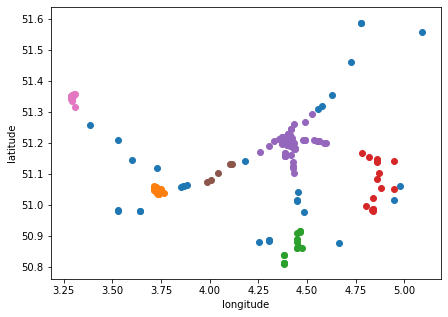

In [6]:
# perform clustering storing corresponding models
model = detection.clustering(df_unique, weights)

print('# clusters {}'.format( len(set(model.labels_))) )    

plt.figure(figsize=(7,5))
for c in sorted(set(model.labels_)):
    mask = model.labels_ == c
    x, y = df_unique.loc[mask,'longitude'], df_unique.loc[mask,'latitude']
    plt.scatter(x, y) 
    plt.xlabel("longitude")
    plt.ylabel("latitude")
plt.show()

## Predict work and home locations

This is done by determining how similar are the cluster representatives with what is believed to be work and home.

In [7]:
# First let's check properties of the features designed to represent work and home
work_features, home_features = detection.get_locations_representation()

print('similarity between work and home: ', 1 - distance.cosine(work_features, home_features))

similarity between work and home:  0.0


In [8]:
# make predictions
df_total, predictions = detection.predict(model, weights, df, df_unique)
  
# show identified locations
print(predictions)  

# showing probabilities for cluster representatives
df_total

{'work': [[51.051, 3.7190000000000003], [50.863, 4.447]], 'home': [[51.21, 4.408]]}


,latitude,longitude,work_prob,home_prob
0,51.051,3.719,0.610957,0.389043
1,50.863,4.447,0.657791,0.342209
2,51.085,4.859,0.454079,0.545921
3,51.210,4.408,0.322556,0.677444
4,51.102,4.043,0.541962,0.458038
5,51.349,3.289,0.446161,0.553839


__Visualize results__

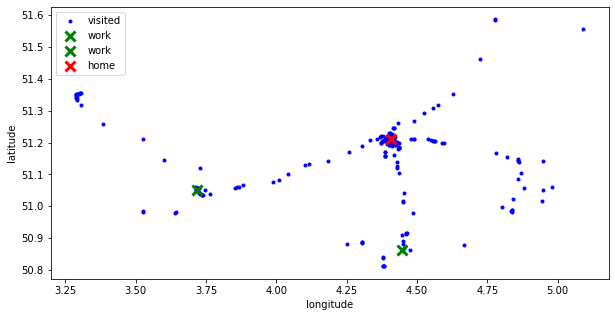

In [9]:
def plot_selected_location(xy, work=None, home=None, title=None):
    plt.figure(figsize=(10,5))
    plt.plot(xy[1], xy[0], 'b.', label='visited')
    if work is not None:
        for w in work:
            plt.plot(w[1], w[0], 'gx', markersize=10, mew=3, label='work')
    if home is not None:
        for h in home:
            plt.plot(h[1], h[0], 'rx', markersize=10, mew=3, label='home')
    if title is not None:
        plt.title(title)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.legend()    
    plt.show()


xy = [df_unique.loc[:,'latitude'], df_unique.loc[:,'longitude']]
work = predictions['work']
home = predictions['home']    
plot_selected_location(xy, work, home)